# Analysis

### Import Dataset

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# original = pd.read_csv("./csv/2018_DATOS_AFOROS_NP_original.csv")
# df = original[original.iloc[:,7:].sum(axis = 1) > 0]

df = pd.read_csv("./csv/Density-of-pedestrians.csv")
df_original = pd.read_csv("./csv/PEATONES_2019.csv", delimiter = ";", encoding= "latin")

### We merge the filtered dataset with the original to regain the dropped columns

In [69]:
l = df.columns.to_list()
l.remove("CÓDIGO_POSTAL")
l.remove("OBSERVACIONES_DIRECCION")
print(l)
m = df.merge(df_original, how = 'inner', on = l)
m.drop(m.columns.to_list()[-2:],axis = 1, inplace = True)
m.rename(columns={"CÓDIGO_POSTAL_x": "CÓDIGO_POSTAL", "OBSERVACIONES_DIRECCION_x": "OBSERVACIONES_DIRECCION"}, inplace = True)
df = m.reindex(df_original.columns, axis=1)


['FECHA', 'HORA', 'PEATONES', 'DISTRITO', 'NOMBRE_VIAL', 'NÚMERO', 'LATITUD', 'LONGITUD']


In [71]:
print(df.shape)
print(df_original.shape)

(284866, 12)
(288749, 12)


In [163]:
df.head()

,FECHA,HORA,IDENTIFICADOR,PEATONES,NÚMERO_DISTRITO,DISTRITO,NOMBRE_VIAL,NÚMERO,CÓDIGO_POSTAL,OBSERVACIONES_DIRECCION,LATITUD,LONGITUD
0,01/01/2019,00:00:00,PERM_PEA02_PM01,497,1.0,Centro,Calle Fuencarral,22,28004,Calle peatonal,40.422009,-3.700892
1,01/01/2019,00:15:00,PERM_PEA02_PM01,244,1.0,Centro,Calle Fuencarral,22,28004,Calle peatonal,40.422009,-3.700892
2,01/01/2019,00:30:00,PERM_PEA02_PM01,179,1.0,Centro,Calle Fuencarral,22,28004,Calle peatonal,40.422009,-3.700892
3,01/01/2019,00:45:00,PERM_PEA02_PM01,174,1.0,Centro,Calle Fuencarral,22,28004,Calle peatonal,40.422009,-3.700892
4,01/01/2019,01:00:00,PERM_PEA02_PM01,131,1.0,Centro,Calle Fuencarral,22,28004,Calle peatonal,40.422009,-3.700892


## Resource naming strategy

- Ontological terms pattern:
`http://www.semanticweb.org/ontologies/pedestrianflow#<term_name>`
- Individuals pattern:
`http://http://www.semanticweb.org/ontologies/pedestrianflow/resource/<resource_type>/<resource_name>`

### Dataset description

Our Dataset has information about the number of pedestrians passing by specific points in madrid in intervals of 15 minutes

In [75]:
df.nunique()

FECHA                       181
HORA                         96
IDENTIFICADOR                18
PEATONES                   2162
NÚMERO_DISTRITO               5
DISTRITO                      5
NOMBRE_VIAL                  17
NÚMERO                       15
CÓDIGO_POSTAL                 9
OBSERVACIONES_DIRECCION       3
LATITUD                      23
LONGITUD                     20
dtype: int64

### Transforms df and plots frequency along the day

In [122]:
def add0(value):
    array = value.split(":")
    if len(array[0])== 1:
        return "0" + array[0] + ":" + array[1] + ":" + array[2]
    else:
        return value

In [148]:
def coord_float(value):
    value = value.replace(",",".")
    return float(value)

In [149]:
df.HORA = df.HORA.transform(add0)
df.LATITUD = df.LATITUD.transform(coord_float)
df.LONGITUD = df.LONGITUD.transform(coord_float)

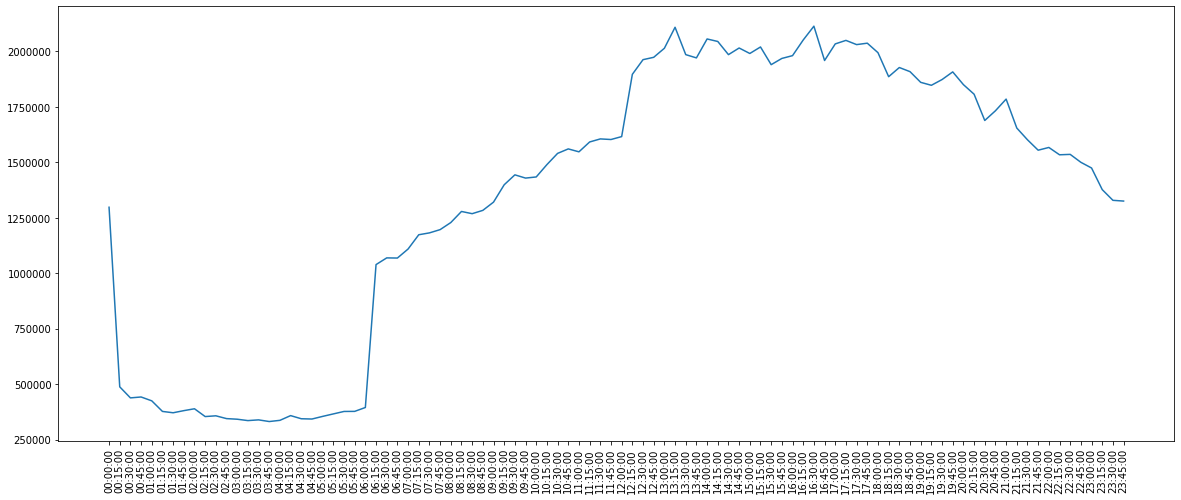

In [129]:
fig = plt.gcf()
fig.set_size_inches(20, 8)
plt.xticks(rotation=90)
plt.plot(df.groupby("HORA").sum()["PEATONES"])

In [130]:
def plot_corr(df, width = 15, height = 14):
    corr_matrix = df.corr()
    f = plt.figure(figsize=(width, height))
    plt.matshow(corr_matrix, fignum=f.number)
    plt.xticks(range(corr_matrix.shape[1]),corr_matrix.columns, fontsize=12, rotation=45)
    plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12)
    plt.colorbar()
    plt.show()

##  Resource naming Strategy

Our resource naming strategy will follow this format (this is an example)
`observation/observationId/locationId/latitude/length/date/2018-05-23/hour#14/vehicle#car/speed#70-80`


## Correlation matrix
Below we can see the correlation matrix across all the meaningfull variables in the dataset.
We can see that there are high correlations between similar velocities (20-30 is close to 30-40, 30-40 to 40-50 ,etc) both in normal vehicle speeds as well as across 2-wheeled vehicle speeds, which makes sense.


In [132]:
aux =  np.isnan(df.corr().values[0])
corr_filter = np.invert(aux)

In [133]:
nan_columns = []
c = df.corr()
for x,y in zip(c.iloc[0],c.keys()):
    if np.isnan(x):
        nan_columns.append(y)

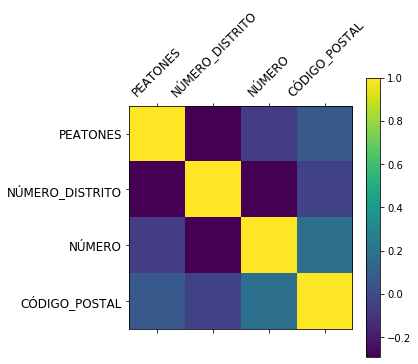

In [135]:
corr_list = [x for x in df.columns if x not in nan_columns]
plot_corr(df[corr_list], 5,5)

In [147]:
a = '-3,7008917'
a = a.replace(",",".")
float(a)

-3.7008917

In [151]:
df.LONGITUD.values

array([-3.7008917, -3.7008917, -3.7008917, ..., -3.713371 , -3.713371 ,
       -3.713371 ])

## Map of the points in Madrid where the measurements where made

In [136]:
import geopandas as gpd
from shapely.geometry import Point, Polygon


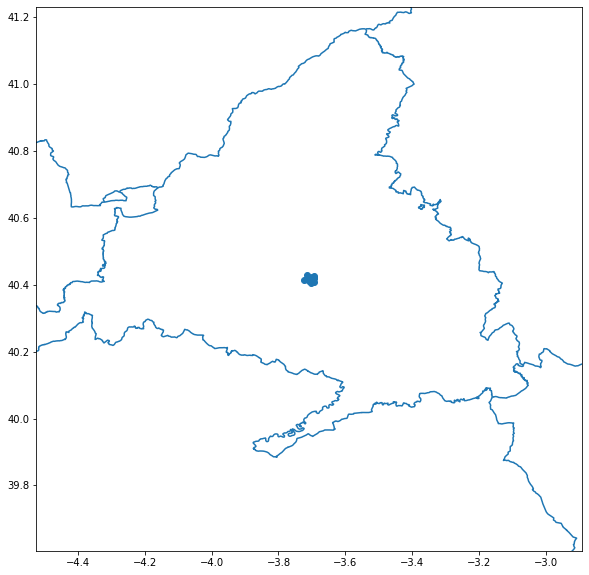

In [154]:
coordinates = df[["LATITUD","LONGITUD"]].groupby(['LATITUD','LONGITUD']).size().reset_index()
geometry = [Point(xy) for xy in zip(coordinates.LONGITUD, coordinates.LATITUD)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(coordinates, crs=crs, geometry=geometry)
#'./map/PORTAL_PK.shp'
spain_map = gpd.read_file('./map/peninsula/ll_provinciales_inspire_peninbal_etrs89.shp')
fig,ax = plt.subplots(figsize = (15,10))
minx, miny, maxx, maxy = gdf.total_bounds
zoomout = 0.8
ax.set_xlim(minx- zoomout, maxx + zoomout)
ax.set_ylim(miny - zoomout, maxy + zoomout)
spain_map.plot(ax = ax)
gdf.plot(ax = ax)